<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: El Nino spectrum</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Methods of time series analysis
1. <a href="#spectrum">Variance density by frequency (power spectrum)</a>
1. <a href="#autocorrelation">Lagged (auto) correlation/covariance</a>
1. <a href="#AR1noise">AR1 model of geophysical processes</a>

--------

In [71]:
!ls ../data

AtmosAngularMomentum   Eq_timelon_sections.nc


In [72]:
%matplotlib inline

from pylab import rcParams, pcolor, show, colorbar, xticks, yticks, title, figure
import matplotlib.pyplot as plt
import numpy as np

from netCDF4 import Dataset

# Trick: a loop over keys, building a command. Then, execute that command!
datafile = Dataset('../data/Eq_timelon_sections.nc',mode='r')

for key in datafile.variables.keys(): 
    print( key +"=datafile['"+key+"'][:].squeeze()") # to show the command
    exec( key +"=datafile['"+key+"'][:].squeeze()")
datafile.close()

lon=datafile['lon'][:].squeeze()
time=datafile['time'][:].squeeze()
olr=datafile['olr'][:].squeeze()
precip=datafile['precip'][:].squeeze()
slp=datafile['slp'][:].squeeze()
sst=datafile['sst'][:].squeeze()
uwnd=datafile['uwnd'][:].squeeze()


Text(0.5,1,'CPAC SST (240 mos, from Jan 1980)')

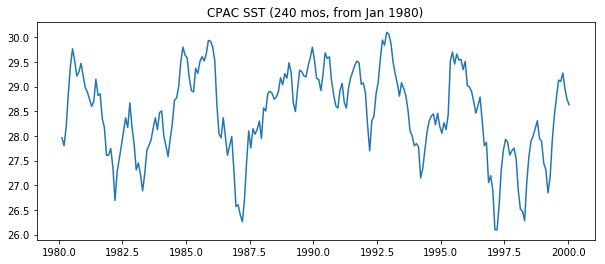

In [73]:
CPAC = sst[:,np.where(lon == 185)].ravel()
# define the time axis as decimal years 
yyyy = 1980 + (time + 0.5)/12.  

fig,ax = plt.subplots(1,1,figsize=(10,4)); 
ax.plot(yyyy, CPAC)
title('CPAC SST (240 mos, from Jan 1980)')

Text(0.5,1,'CPAC SST anomaly (240 mos, from Jan 1980)')

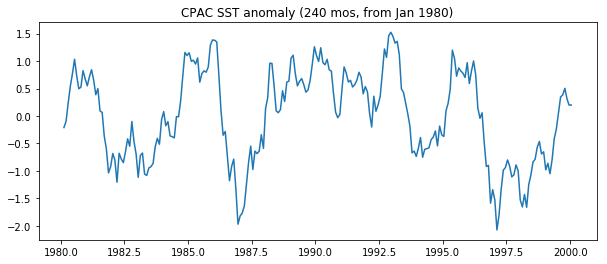

In [90]:
CPACA = CPAC.copy() # Anomaly time series of same size

# Remove seasonal cycle 
calmos = np.arange(12) ## Runs from 0-11, not 1-12, CAREFUL! 
# I happen to know the data begin with a January. CAREFUL! Not a general approach
months = np.arange(len(CPAC)) 
for imo in calmos:
    yess = np.where(imo == months%12)
    CPACA[yess] -= np.mean(CPAC[ yess ] )
    
# CPACA -= np.mean(CPAC) 

fig,ax = plt.subplots(1,1,figsize=(10,4)); 
ax.plot(yyyy, CPACA)
title('CPAC SST anomaly (240 mos, from Jan 1980)')

----------------
<a name="spectrum"></a>
### Is there a "significant" periodicity to ENSO?

Let's look at the power spectrum

Text(0.5,1,'real part: the mean, then a symmetric repeat of the spectrum')

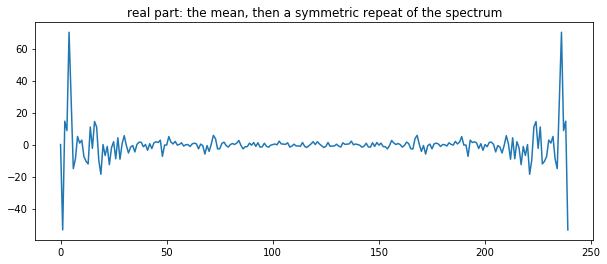

In [91]:
# Take the simple FFT, after removing the mean

V = CPACA; NT = len(V)
Vp = V - V.mean()
Vspec = np.fft.fft( Vp )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax = plt.subplots(1,1,figsize=(10,4)); 
ax.plot(Vspec.real)
plt.title('real part: the mean, then a symmetric repeat of the spectrum')
#ax.plot(Vspec.imag)

In [92]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)

freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

# Power spectrum is the squared amplitude of the spectrum

Variance is 0.69002205 (m/s)^2: matches 0.6900220513343812


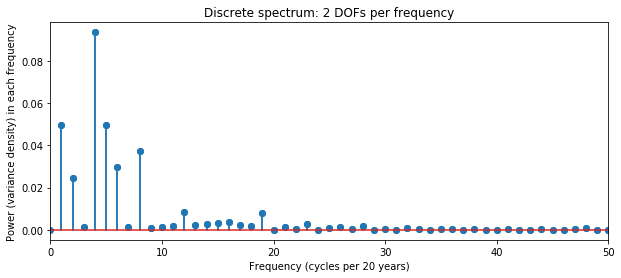

In [93]:
# Complex conjugate does the squaring
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vp) / Power.sum()       # Enforce Parseval's theorem for variance 
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.stem(freqs, Power)
ax.set_xlim([0,50])
ax.set_xlabel('Frequency (cycles per 20 years)')
ax.set_ylabel('Power (variance density) in each frequency')
plt.title('Discrete spectrum: 2 DOFs per frequency')

print('Variance is', Vp.var(), '(m/s)^2: matches', sum(Power))

Text(0.5,1,'P(f) as a line graph')

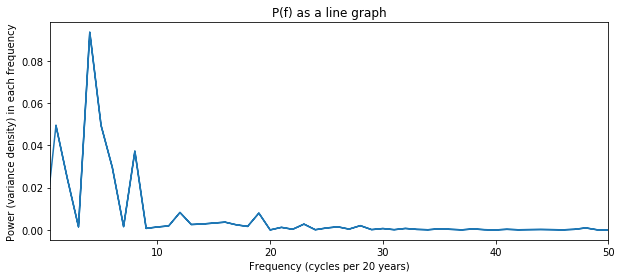

In [124]:
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.plot(freqs, Power)
ax.set_xlim([0.5,50])
ax.set_xlabel('Frequency (cycles per 20 years)')
ax.set_ylabel('Power (variance density) in each frequency')
plt.title('P(f) as a line graph')


Text(0.5,1,'Semilog-x: area under curve NOT proportional to variance')

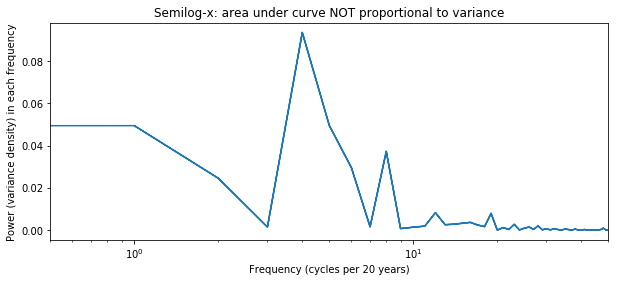

In [125]:
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.semilogx(freqs, Power)
ax.set_xlim([0.5,50])
ax.set_xlabel('Frequency (cycles per 20 years)')
ax.set_ylabel('Power (variance density) in each frequency')
plt.title('Semilog-x: area under curve NOT proportional to variance')


Text(0.5,1,'Area under the curve proportional to variance')

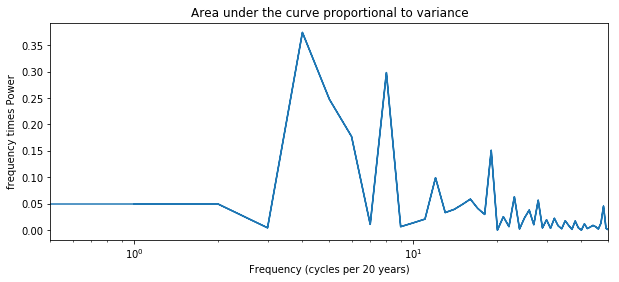

In [126]:
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.semilogx(freqs, freqs*Power)
ax.set_xlim([0.5,50])
ax.set_xlabel('Frequency (cycles per 20 years)')
ax.set_ylabel('frequency times Power')
plt.title('Area under the curve proportional to variance')


------------
<a name='autocorrelation'></a>
# Autocorrelation and autocovariance 

In [94]:
# very manual loop over lags 
MAXLAG=36
lags = np.arange(-MAXLAG,MAXLAG)
cxx=0.*lags

for ind,tau in enumerate(lags):
    if tau<0:
        cxx[ind]=np.mean(Vp[:tau]*Vp[-tau:])
    elif tau==0:
        cxx[ind]=np.mean(Vp*Vp)
    else:
        cxx[ind]=np.mean(Vp[:-tau]*Vp[tau:])
        

Text(0.5,1,'variance is 0.69002205')

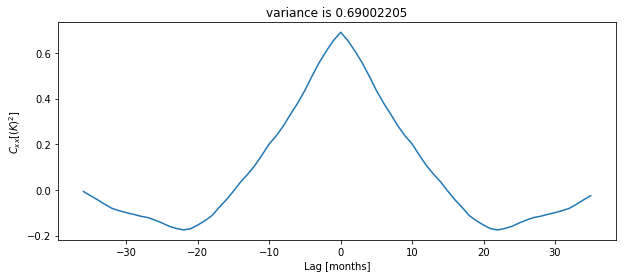

In [95]:
fig,ax = plt.subplots(1,1,figsize=(10,4)); 
ax.plot(lags,cxx)
ax.set_xlabel('Lag [months]')
ax.set_ylabel('$C_{xx} [(K)^2]$')
ax.set_title('variance is '+str(np.var(Vp)))

We define the **lag correlation coefficient** as
\begin{equation}
    \rho_{xy}(\tau) = \frac{C_{xy}(\tau)}{\sigma_x\sigma_y}
\end{equation}

This is unitless, and note that $\rho_{xx}(0)=1$.  

(-1, 1)

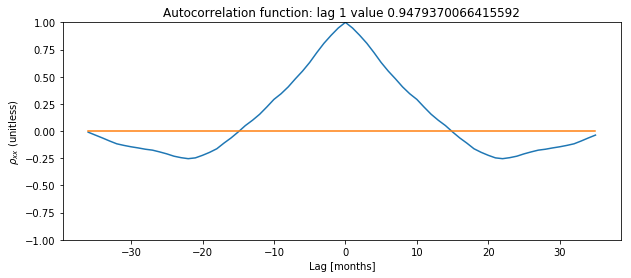

In [96]:
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.plot(lags,cxx/np.var(Vp))
ax.plot(lags,cxx/np.var(Vp)*0)

ax.set_xlabel('Lag [months]')
ax.set_ylabel(r'$\rho_{xx}$ (unitless)')
ax.set_title('Autocorrelation function: lag 1 value ' + str(cxx[MAXLAG+1]/cxx[MAXLAG]))

ax.set_ylim([-1,1])

------------

<a name='AR1'></a>
# Autoregression as a model for geophysical "noise"

## Let's look at central Pacific (anomalous) SST again

Text(0.5,1,'SST and prior month SST')

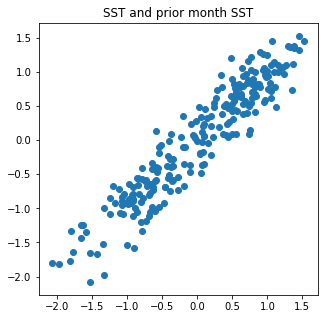

In [97]:
CPAC_1 = np.roll(CPACA,-1) # same data rolled back one month

fig,ax = plt.subplots(1,1,figsize=(5,5)); 

ax.scatter(CPACA, CPAC_1)
ax.set_title('SST and prior month SST')

In [47]:
# c = np.corrcoef(CPAC, np.roll(CPAC,-1))[0,1] # Since the variances are the same, reg = cor

In [98]:
import scipy, scipy.stats

slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(CPACA,CPAC_1)
    
Prediction = intercept + slope*CPAC_1
print( slope, intercept )
print("r-squared:", r_value**2)

0.9437326284756115 5.813247653044413e-09
r-squared: 0.8906312740494865


In [99]:
resid = CPACA - Prediction

Text(0.5,1,'SST and residual (uncorrelated, by least squares principle)')

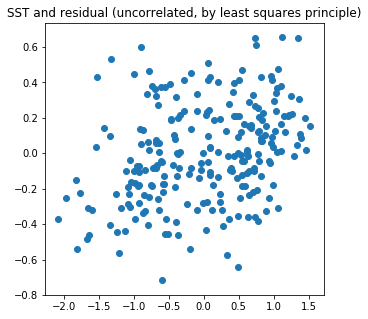

In [100]:
fig,ax = plt.subplots(1,1,figsize=(5,5)); 

ax.scatter(CPACA, resid)
ax.set_title('SST and residual (uncorrelated, by least squares principle)')

## Why not model that uncorrelated residual with random noise? 

In [105]:
# Random white normal noise, of proper standard deviation
sigma = np.std(resid)

# Make some fake data
FAKE = CPAC*0 + np.mean(CPACA) # right shaped container, with mean value set

# Start from the actual value, then fit the subsequent ones with the regression plus fake noise 
FAKE[0] = CPACA[0]
for i in 1+np.arange(len(CPAC)-1): 
    FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma


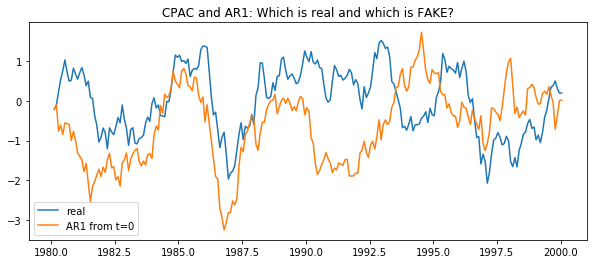

In [106]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(yyyy, CPACA, label='real')
ax.plot(yyyy, FAKE, label='AR1 from t=0')
title('CPAC and AR1: Which is real and which is FAKE?')

plt.legend(loc="best")

# A series of hindcasts 
## of realistically noisy time series

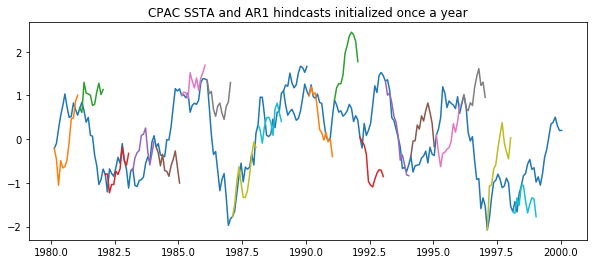

In [107]:
# Hindcasts of 1 year length: the container 
cast = np.arange(12)+100.0

# Initialized every year in January, the number of the year is inityear 
inityear = np.arange(19)

fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(yyyy, CPACA)
plt.title('CPAC SSTA and AR1 hindcasts initialized once a year')

# Start from the actual value, then fit the subsequent ones with the regression plus fake noise 
for icast in inityear: 
    cast[0] = CPACA[12*inityear[icast]]    
    for i in 1+np.arange(len(cast)-1): 
        cast[i] = intercept + slope*cast[i-1] + np.random.randn()*sigma
# plot it 
#    print(icast, yyyy[icast*12]+np.arange(12)/12.)
    ax.plot(     yyyy[icast*12]+np.arange(12)/12., cast)

## Of just the deterministic part (AR1 autoregression)

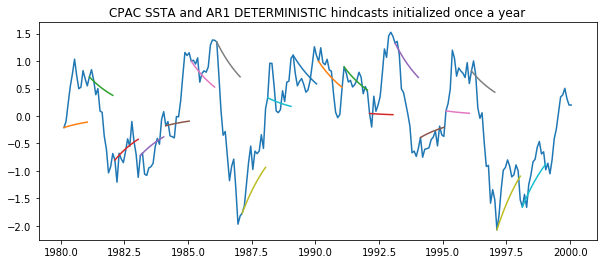

In [108]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(yyyy, CPACA)
plt.title('CPAC SSTA and AR1 DETERMINISTIC hindcasts initialized once a year')

# Start from the actual value, then fit the subsequent ones with the regression plus fake noise 
for icast in inityear: 
    cast[0] = CPACA[12*inityear[icast]]    
    for i in 1+np.arange(len(cast)-1): 
        cast[i] = intercept + slope*cast[i-1] # + np.random.randn()*sigma
# plot it 
#    print(icast, yyyy[icast*12]+np.arange(12)/12.)
    ax.plot(     yyyy[icast*12]+np.arange(12)/12., cast)